# Sound Event Classification with ESC-50

We'll be working with the popular environmental sound classification dataset: **[ESC-50](https://github.com/karolpiczak/ESC-50)** for these experiments. 

A few notes about the ESC-50 data:
- 2000 x 5-second long audio recordings in .wav format, in the `audio/*.wav` folder
- original audio has 44.1 kHz sample rate, mono
- metadata can be found in `meta/esc50.csv`
    - `target` is the target class index, while `category` is the name of that class
    - `fold` contains predefined cross-validation folds. For our purposes, we'll use folds 1-3 for training, 4 for val, and 5 for test

### Loading data and preliminary analysis

In [ ]:
data_path = "/projects/Machine_Listening/ESC-50-master" 
meta_df = pd.read_csv(f"{data_path}/meta/esc50.csv")
print(meta_df.head())


            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


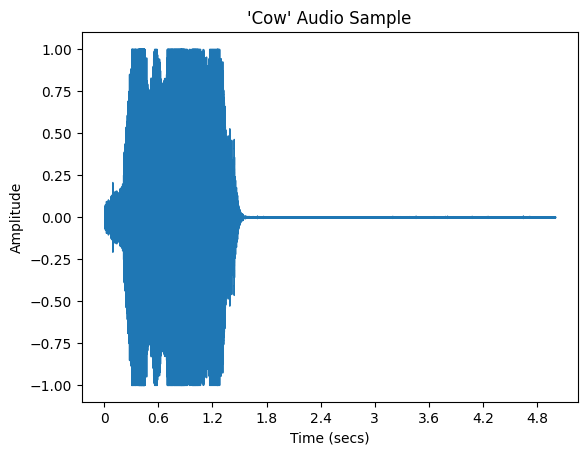

Sample Rate: 44100 Hz
Num of Audio Samples: 220500


In [ ]:
import IPython.display as ipd

# An audio file from the `cow` class using Librosa.
filename = meta_df[meta_df["category"] == "cow"]["filename"].iloc[0]
file_path = os.path.join(data_path, "audio", filename)
cow_audio, sample_rate = librosa.load(file_path, sr=None)

librosa.display.waveshow(cow_audio, sr=sample_rate)
plt.xlabel("Time (secs)")
plt.ylabel("Amplitude")
plt.title("'Cow' Audio Sample")
plt.show()

print('Sample Rate:', sample_rate, 'Hz')
print('Num of Audio Samples:', len(cow_audio))

ipd.display(ipd.Audio(cow_audio, rate=sample_rate))

#### Spectrogram Exploration:

1. linear-frequency power spectrogram
2. log-frequency spectrogram
3. log-mel frequency spectrogram

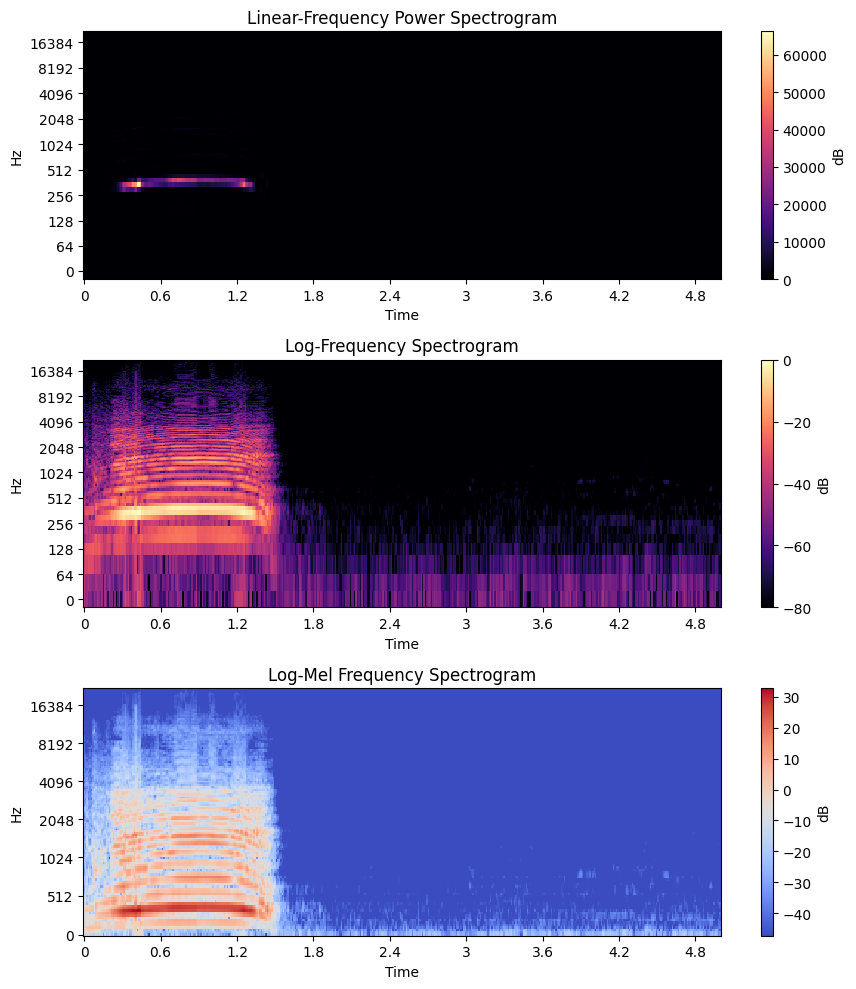

In [ ]:
# Initial window/hop sizes and n_mels
win_length = 1024
hop_length = 1024//2
n_mels = 128

# Define spectrograms
STFT_cow_audio = librosa.stft(cow_audio, n_fft=win_length, hop_length=hop_length)
lin_power_spec = np.abs(STFT_cow_audio) ** 2  
log_spec = librosa.power_to_db(lin_power_spec, ref=np.max)
mel_spec = librosa.feature.melspectrogram(y=cow_audio, sr=sample_rate, n_fft=win_length, hop_length=hop_length, n_mels=n_mels)
log_mel_spec = librosa.power_to_db(mel_spec) 

plt.figure(figsize=(9, 10))

# Linear Power Spectrogram
plt.subplot(3, 1, 1)
librosa.display.specshow(lin_power_spec, sr=sample_rate, hop_length=hop_length, x_axis="time", y_axis="log")
plt.colorbar(label="dB")
plt.title("Linear-Frequency Power Spectrogram")

# Log-Frequency Spectrogram
plt.subplot(3, 1, 2)
librosa.display.specshow(log_spec, sr=sample_rate, hop_length=hop_length, x_axis="time", y_axis="log")
plt.colorbar(label="dB")
plt.title("Log-Frequency Spectrogram")

# Log-Mel Spectrogram
plt.subplot(3, 1, 3)
librosa.display.specshow(log_mel_spec, sr=sample_rate, hop_length=hop_length, x_axis="time", y_axis="mel")
plt.colorbar(label="dB")
plt.title("Log-Mel Frequency Spectrogram")

plt.tight_layout()
plt.show()

Differences between the 3 types of spectrograms above (i.e. for one set of parameters):

1. Linear-Frequency Power Spectrogram:

    - Shows the raw power of frequencies over time
    - Makes high-frequency components hard to distinguish (because it is dominated by low frequencies)
    - High-energy bands at lower frequencies overpower other details

3. Log-Frequency Spectrogram:

    - Higher frequencies are more visible (frequency axis is log-scaled)
    - Reveals harmonic structures that may be hidden in the linear spectrogram 
    - Shows raw energy levels (can be noisy for classification tasks)

4. Log-Mel Spectrogram:

    - Closer human perception of sound
    - Focuses more on low-mid frequencies while compressing high frequencies effectively
    - Noise is reduced, and spectral patterns appear smoother and more interpretable


The Log-Mel Spectrogram is the best choice for training a sound event classifier. Mel scale emphasizes frequency regions important for human hearing. It also reduces unnecessary frequency details and ensures a better dynamic range with log transformation. It also has lower sensitivity to noise, which makes it more robust for real-world sound classification.

Experimenting with win_length=512, hop_length=256


/ext3/miniconda3/lib/python3.8/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


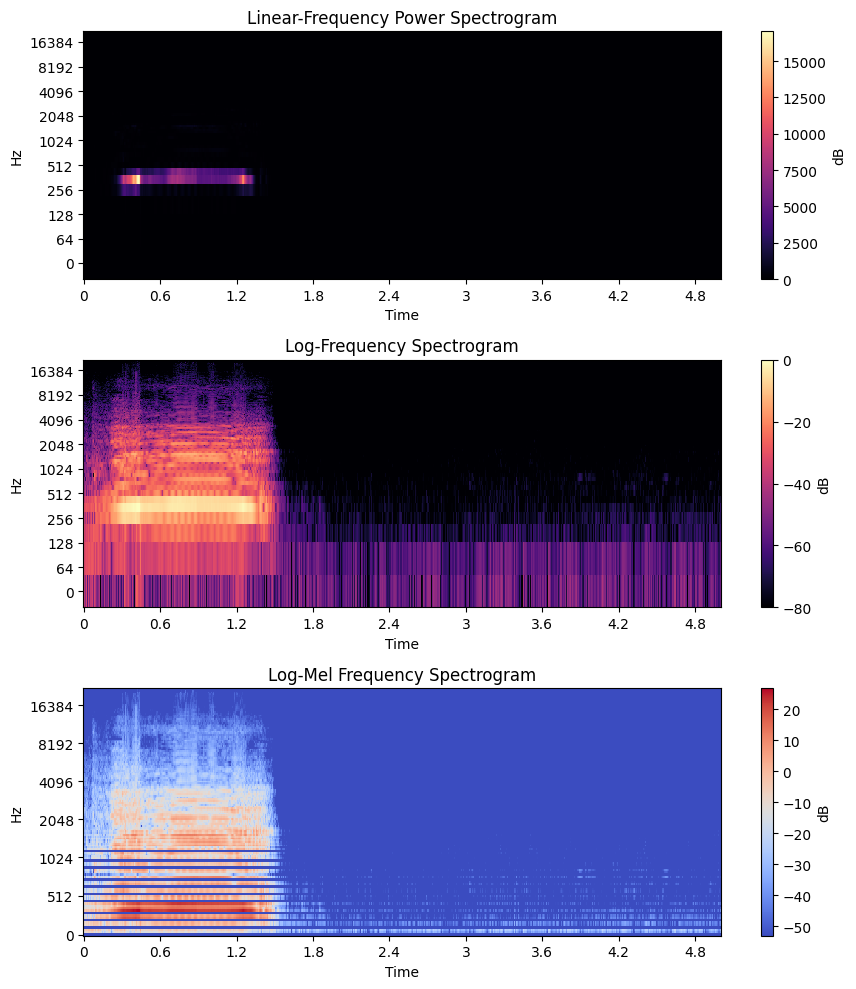

Experimenting with win_length=1024, hop_length=256


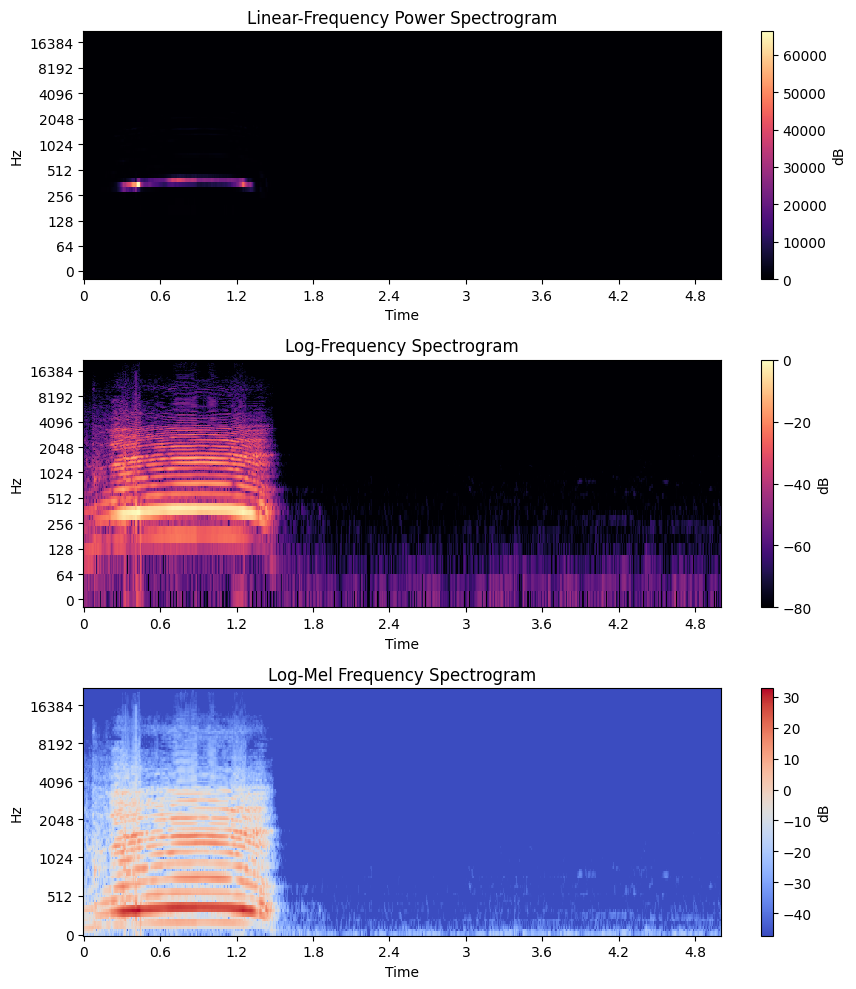

Experimenting with win_length=2048, hop_length=512


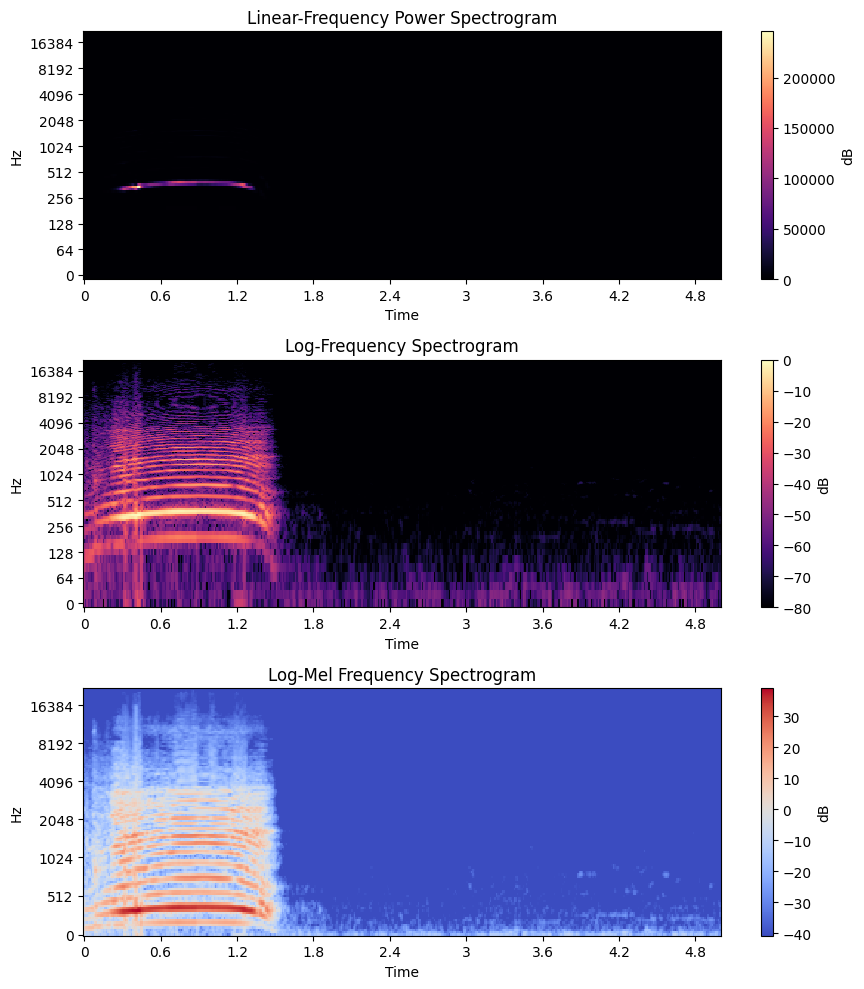

Experimenting with win_length=2048, hop_length=1024


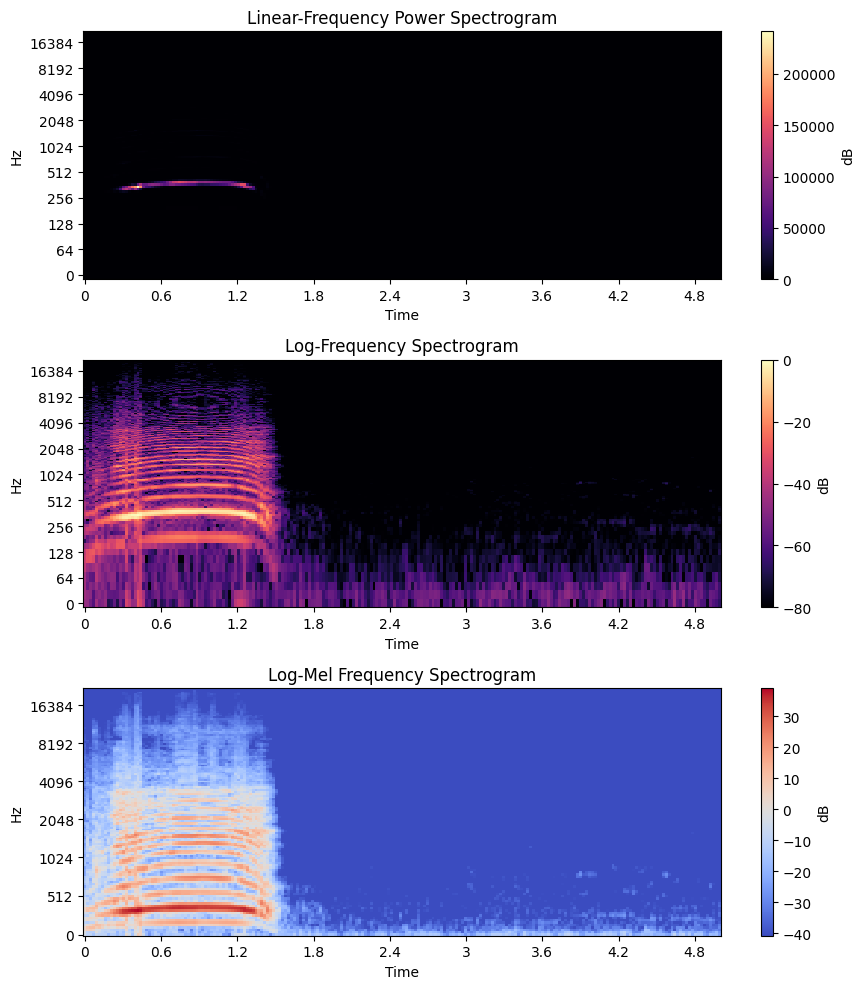

In [9]:
# different combinations of window lengths and hop lengths:
params = [
    (512, 256),    # Smaller win_length, Smaller hop_length
    (1024, 256),   # Medium win_length, Smaller hop_length
    (2048, 512),   # Larger win_length, Medium hop_length
    (2048, 1024),  # Larger win_length, Larger hop_length
]


for win_length, hop_length in params:
    print(f"Experimenting with win_length={win_length}, hop_length={hop_length}")


    STFT_cow_audio = librosa.stft(cow_audio, n_fft=win_length, hop_length=hop_length)
    lin_power_spec = np.abs(STFT_cow_audio) ** 2  
    log_spec = librosa.power_to_db(lin_power_spec, ref=np.max)
    mel_spec = librosa.feature.melspectrogram(y=cow_audio, sr=sample_rate, n_fft=win_length, hop_length=hop_length, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec) 


    plt.figure(figsize=(9, 10))

    # Linear Power Spectrogram
    plt.subplot(3, 1, 1)
    librosa.display.specshow(lin_power_spec, sr=sample_rate, hop_length=hop_length, x_axis="time", y_axis="log")
    plt.colorbar(label="dB")
    plt.title("Linear-Frequency Power Spectrogram")
    
    # Log-Frequency Spectrogram
    plt.subplot(3, 1, 2)
    librosa.display.specshow(log_spec, sr=sample_rate, hop_length=hop_length, x_axis="time", y_axis="log")
    plt.colorbar(label="dB")
    plt.title("Log-Frequency Spectrogram")
    
    # Log-Mel Spectrogram
    plt.subplot(3, 1, 3)
    librosa.display.specshow(log_mel_spec, sr=sample_rate, hop_length=hop_length, x_axis="time", y_axis="mel")
    plt.colorbar(label="dB")
    plt.title("Log-Mel Frequency Spectrogram")

    plt.tight_layout()
    plt.show()


# Explanation of Parameter Choices:

I tested four different window and hop length combinations to analyze how these parameters impact the spectrogram representation of environmental sounds. The impact is as follows:

1. Larger win_length: Better frequency resolution (sharper harmonic details) - Worse time resolution (smearing in time domain)

2. Smaller win_length: Better time resolution (captures transients) - Worse frequency resolution (blurry spectral bands)

3. Smaller hop_length: Smoother transitions in spectrogram - Higher computational cost (more frames)

4. Larger hop_length:  Faster computation (fewer overlapping frames) - More discontinuities in time resolution


I think the best trade-off was found with win_length=2048, hop_length=512, which captures both sharp transients and continuous sounds, making it optimal for environmental sound classification, where a mix of short and long-duration sounds exist.

### Feature Extraction
Next, we expand this feature extraction such that we can apply it to an entire data split and have a bit more flexibility.

In [ ]:
def get_esc_features(audio_filepaths, feature, sr=16000, aggregation="mean", hop_length=512, win_length=1024):
    """
    Process a list of audio files to extract specified features.
    You'll aggregate the features over time, by averaging or taking the max.
    
    Parameters:
    -----------
    audio_filepaths : list of str)
        List of paths to audio files.
    feature : str
        Feature type to extract. One of "lin_spec", "log_spec", "log_mel_spec".
    sr : int, optional
        Target sampling rate for resampling. Default is 16000.
    aggregation : str, optional 
        Aggregation method over time. Either "mean" or "max". Default is "mean".
    hop_length : int, optional
        Hop length for feature extraction. Default is 512.
    win_length : int, optional
        Window length for feature extraction. Default is 1024.
    
    Returns:
    -----------
        np.ndarray: A NumPy array of shape (n_files, n_features). n_features will differ based on feature type.
    """
    feature_list = []
    
    for audio_file in tqdm(audio_filepaths):
        
        # Load and resample audio to sr
        y, _ = librosa.load(audio_file, sr=sr)
        STFT = librosa.stft(y, n_fft=win_length, hop_length=hop_length)
    
        # Extract features depending on 'feature' arg
        if feature == "lin_spec":
            spec = np.abs(STFT) ** 2  # Linear power spectrogram
        elif feature == "log_spec":
            lin_power_spec = np.abs(STFT) ** 2  
            spec = librosa.power_to_db(lin_power_spec, ref=np.max) # Log-Frequency spectrogram
        elif feature == "log_mel_spec":
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=win_length, hop_length=hop_length, n_mels=128)
            spec = librosa.power_to_db(mel_spec, ref=np.max)  # Log-Mel spectrogram
        else:
            raise ValueError("Invalid feature type.")


        # Aggregate over time depending on 'aggregation' arg
        if aggregation == "mean":
            feature_vector = np.mean(spec, axis=1)  
        elif aggregation == "max":
            feature_vector = np.max(spec, axis=1)  
        else:
            raise ValueError("Invalid aggregation type.")

        
        feature_list.append(feature_vector)

    
    return np.array(feature_list)

In [ ]:
data_path = "/projects/Machine_Listening/ESC-50-master" 

# Demo on 10 files
data_chunk = [os.path.join(data_path, f"audio/{i}") for i in list(meta_df['filename'])][:10] 

# params for spec computation
resample_sr = 16000
agg_type = "mean"
hop_len = 512
win_len = 2048

lin_spec_ft  = get_esc_features(data_chunk, feature="lin_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
log_spec_ft  = get_esc_features(data_chunk, feature="log_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
log_mel_spec_ft  = get_esc_features(data_chunk, feature="log_mel_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)

# Test output shape 
assert lin_spec_ft.shape == (10, 1025)
assert log_spec_ft.shape == (10, 1025)
assert log_mel_spec_ft.shape == (10, 128)


100%|██████████| 10/10 [00:00<00:00, 59.86it/s]


***Adding Spectral Contrast:***

***Spectral Contras measures the difference between peaks and valleys in a spectrum across frequency bands, and helps distinguish between different textures of sounds.***

***Higher contrast → More variation (e.g., percussive sounds, speech).
Lower contrast → Smooth, steady sounds (e.g., wind, engine noise).***

In [12]:
def get_esc_features(audio_filepaths, feature, sr=16000, aggregation="mean", hop_length=512, win_length=1024):
    """
    Process a list of audio files to extract specified features.
    You'll aggregate the features over time, by averaging or taking the max.
    
    Parameters:
    -----------
    audio_filepaths : list of str
        List of paths to audio files.
    feature : str
        Feature type to extract. One of "lin_spec", "log_spec", "log_mel_spec", "spectral_contrast".
    sr : int, optional
        Target sampling rate for resampling. Default is 16000.
    aggregation : str, optional 
        Aggregation method over time. Either "mean" or "max". Default is "mean".
    hop_length : int, optional
        Hop length for feature extraction. Default is 512.
    win_length : int, optional
        Window length for feature extraction. Default is 1024.
    n_fft : int, optional
        FFT size for STFT. Default is 2048.
    n_mels : int, optional
        Number of Mel filter banks for Mel spectrogram. Default is 128.
    
    Returns:
    -----------
    np.ndarray: A NumPy array of shape (n_files, n_features). n_features will differ based on feature type.
    """
    feature_list = []
    
    for audio_file in tqdm(audio_filepaths, desc="Extracting Features"):
        # Load and resample audio
        y, _ = librosa.load(audio_file, sr=sr)

        # Compute STFT
        STFT = librosa.stft(y, n_fft=win_length, hop_length=hop_length)

        # Extract features depending on 'feature' arg
        if feature == "lin_spec":
            spec = np.abs(STFT) ** 2  # Linear power spectrogram
        elif feature == "log_spec":
            lin_power_spec = np.abs(STFT) ** 2  
            spec = librosa.power_to_db(lin_power_spec, ref=np.max)  # Log-Frequency spectrogram
        elif feature == "log_mel_spec":
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=win_length, hop_length=hop_length, n_mels=128)
            spec = librosa.power_to_db(mel_spec, ref=np.max)  # Log-Mel spectrogram
        elif feature == "spectral_contrast":
            spec = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=win_length, hop_length=hop_length)  # Spectral Contrast
        else:
            raise ValueError(f"Invalid feature type.")

        # Aggregate over time using mean or max
        if aggregation == "mean":
            feature_vector = np.mean(spec, axis=1)
        elif aggregation == "max":
            feature_vector = np.max(spec, axis=1)
        else:
            raise ValueError(f"Invalid aggregation type")

        feature_list.append(feature_vector)     

    return np.array(feature_list)


In [ ]:
data_path = "/projects/Machine_Listening/ESC-50-master" 

# Demo on 10 files
data_chunk = [os.path.join(data_path, f"audio/{i}") for i in list(meta_df['filename'])][:10] 

# params for spec computation
resample_sr = 16000
agg_type = "mean"
hop_len = 512
win_len = 2048

lin_spec_ft  = get_esc_features(data_chunk, feature="lin_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
log_spec_ft  = get_esc_features(data_chunk, feature="log_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
log_mel_spec_ft  = get_esc_features(data_chunk, feature="log_mel_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
spectral_contrast_ft = get_esc_features(data_chunk, feature="spectral_contrast", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)

# Test output shape 
assert lin_spec_ft.shape == (10, 1025)
assert log_spec_ft.shape == (10, 1025)
assert log_mel_spec_ft.shape == (10, 128)
assert spectral_contrast_ft.shape == (10, 7)


Extracting Features: 100%|██████████| 10/10 [00:00<00:00, 70.67it/s]


***We see that all tests are passed. Since spectral_contrast has 7 frequency bands, its expected shape is (10, 7)***

### Data Splitting 
Next, we set up our **train/validation/test** splits. Use folds 1-3 for training, 4 for validation, and 5 for testing.

We split the data into training and test lists of audio files (`X`) and their corresponding category labels (`y`). 

In [ ]:
train = meta_df[meta_df["fold"].isin([1, 2, 3])]
val = meta_df[meta_df["fold"] == 4]
test = meta_df[meta_df["fold"] == 5]

train_filepaths = [os.path.join(data_path, "audio", fname) for fname in train["filename"]]
val_filepaths = [os.path.join(data_path, "audio", fname) for fname in val["filename"]]
test_filepaths = [os.path.join(data_path, "audio", fname) for fname in test["filename"]]

train_labels = list(train["target"])
val_labels = list(val["target"])
test_labels = list(test["target"])

from collections import Counter

print(f"Train: {Counter(train_labels)}")
print(f"Validation: {Counter(val_labels)}")
print(f"Test: {Counter(test_labels)}")

print(f"\nTotal samples: Train={len(train_filepaths)}, Validation={len(val_filepaths)}, Test={len(test_filepaths)}")

Train: Counter({0: 24, 14: 24, 36: 24, 19: 24, 30: 24, 34: 24, 9: 24, 22: 24, 48: 24, 41: 24, 47: 24, 31: 24, 17: 24, 45: 24, 8: 24, 15: 24, 46: 24, 37: 24, 32: 24, 16: 24, 25: 24, 4: 24, 3: 24, 27: 24, 43: 24, 12: 24, 40: 24, 29: 24, 10: 24, 7: 24, 26: 24, 6: 24, 44: 24, 23: 24, 20: 24, 49: 24, 24: 24, 39: 24, 28: 24, 18: 24, 2: 24, 35: 24, 38: 24, 21: 24, 1: 24, 11: 24, 42: 24, 5: 24, 33: 24, 13: 24})
Validation: Counter({49: 8, 42: 8, 33: 8, 25: 8, 48: 8, 18: 8, 5: 8, 19: 8, 46: 8, 40: 8, 4: 8, 7: 8, 2: 8, 26: 8, 9: 8, 16: 8, 27: 8, 36: 8, 41: 8, 37: 8, 24: 8, 21: 8, 32: 8, 14: 8, 10: 8, 47: 8, 13: 8, 1: 8, 12: 8, 45: 8, 11: 8, 20: 8, 15: 8, 17: 8, 44: 8, 23: 8, 3: 8, 34: 8, 43: 8, 38: 8, 28: 8, 30: 8, 0: 8, 29: 8, 8: 8, 22: 8, 31: 8, 6: 8, 39: 8, 35: 8})
Test: Counter({2: 8, 42: 8, 16: 8, 35: 8, 27: 8, 20: 8, 4: 8, 18: 8, 19: 8, 48: 8, 33: 8, 5: 8, 41: 8, 26: 8, 40: 8, 24: 8, 46: 8, 43: 8, 10: 8, 36: 8, 12: 8, 21: 8, 45: 8, 3: 8, 1: 8, 7: 8, 8: 8, 11: 8, 38: 8, 0: 8, 29: 8, 13: 8, 

***We can see that each class has 24 samples in the training set → This is expected since we used folds 1-3 for training, each class has 8 * 3 = 24 samples. Each class has 8 samples in validation and test → Since we used fold 4 for validation & fold 5 for test, all classes have exactly 8 samples per fold.***

### Model Selection 

In [ ]:
def train_and_validate(models, features, norm, lambdas, X_train_dict, y_train, X_val_dict, y_val):
    """
    Trains and evaluates models with different hyperparameter combinations on a training and validation set.

    Parameters:
    -----------
    models : list of str
        List of models to evaluate. Options: ['log_reg', 'svm'].
    features : list of str
        List of feature representations. Options: ['lin_spec', 'log_spec', 'log_mel_spec'].
    norm : bool
        Whether to apply normalization (True/False).
    lambdas : list of float
        List of regularization strengths (inverted for `C` parameter).
    X_train_dict : dict
        Dictionary containing feature datasets for training (keys are feature names, values are corresponding arrays).
    y_train : array-like
        Training labels.
    X_val_dict : dict
        Dictionary containing feature datasets for validation (keys are feature names, values are corresponding arrays).
    y_val : array-like
        Validation labels.

    Returns:
    --------
    results : list of dict
        A list of dictionaries containing model configurations and their validation accuracies.

        Each model configuration should give you a dictionary like so: 
            curr_results = { 'model': m,
                        'feature': f,
                        'normalized': norm,
                        'lambda': lam,
                        'val_accuracy': accuracy,
                        'val_precision': precision,
                        'val_recall': recall,
                        'val_f1_score': f1 }
    """
    results = []
    
    for f in features: 
        # Retrieve feature matrices
        # TODO 
        X_train = X_train_dict[f]
        X_val = X_val_dict[f]
        
        # Min-max scaling
        if norm:
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
        
        for m in models:
            for lam in lambdas:
                print(f'\nNow training: feature: {f} || model: {m} || lambda: {lam} || norm: {norm}')
                
                # Model training
                if m == "log_reg":
                    model = LogisticRegression(C=1/lam, penalty="l2", solver="lbfgs", max_iter=1000)
                elif m == "svm":
                    model = LinearSVC(C=1/lam, max_iter=1000, dual=False)
                else:
                    raise ValueError(f"Invalid model")
                
                # Fit model
                model.fit(X_train, y_train)
                
                # Predictions on validation set
                y_pred = model.predict(X_val)
                
                # Compute performance metrics
                accuracy = accuracy_score(y_val, y_pred)
                precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
                recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
                f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

                curr_results = {
                    'model': m,
                    'feature': f,
                    'normalized': norm,
                    'lambda': lam,
                    'val_accuracy': accuracy,
                    'val_precision': precision,
                    'val_recall': recall,
                    'val_f1_score': f1
                }
                print(curr_results)
                
                results.append(curr_results)
                    
    return results


In [ ]:
# MEAN pooling over time

resample_sr = 16000
agg_type = "mean"
hop_len = 512
win_len = 1024

X_train_lin_spec_mean  = get_esc_features(train_filepaths, feature="lin_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
X_train_log_spec_mean  = get_esc_features(train_filepaths, feature="log_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
X_train_log_mel_spec_mean  = get_esc_features(train_filepaths, feature="log_mel_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)

X_val_lin_spec_mean  = get_esc_features(val_filepaths, feature="lin_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
X_val_log_spec_mean  = get_esc_features(val_filepaths, feature="log_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
X_val_log_mel_spec_mean  = get_esc_features(val_filepaths, feature="log_mel_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)

# Set up feature dictionaries
X_train_dict_mean = {
    'lin_spec': X_train_lin_spec_mean,
    'log_spec': X_train_log_spec_mean,
    'log_mel_spec': X_train_log_mel_spec_mean,
}

X_val_dict_mean = {
    'lin_spec': X_val_lin_spec_mean,
    'log_spec': X_val_log_spec_mean,
    'log_mel_spec': X_val_log_mel_spec_mean
}


Extracting Features: 100%|██████████| 400/400 [00:05<00:00, 77.09it/s]


In [ ]:
# MAX temporal pooling 
resample_sr = 16000
agg_type = "max"
hop_len = 512
win_len = 1024


X_train_lin_spec_max  = get_esc_features(train_filepaths, feature="lin_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
X_train_log_spec_max  = get_esc_features(train_filepaths, feature="log_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
X_train_log_mel_spec_max  = get_esc_features(train_filepaths, feature="log_mel_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)

X_val_lin_spec_max  = get_esc_features(val_filepaths, feature="lin_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
X_val_log_spec_max  = get_esc_features(val_filepaths, feature="log_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)
X_val_log_mel_spec_max  = get_esc_features(val_filepaths, feature="log_mel_spec", sr=resample_sr, aggregation=agg_type, hop_length=hop_len, win_length=win_len)



# Set up feature dictionaries
X_train_dict_max = {
    'lin_spec': X_train_lin_spec_max,
    'log_spec': X_train_log_spec_max,
    'log_mel_spec': X_train_log_mel_spec_max,
}

X_val_dict_max = {
    'lin_spec': X_val_lin_spec_max,
    'log_spec': X_val_log_spec_max,
    'log_mel_spec': X_val_log_mel_spec_max
}


Extracting Features: 100%|██████████| 400/400 [00:06<00:00, 64.35it/s]


In [ ]:
# MEAN pooled features
results = train_and_validate(
    models=['log_reg', 'svm'],
    features=['lin_spec', 'log_spec', 'log_mel_spec'],
    norm=True,
    lambdas=[0.01, 1, 10],
    X_train_dict=X_train_dict_mean,
    y_train=train_labels,
    X_val_dict=X_val_dict_mean,
    y_val=val_labels
)

pd.DataFrame(results)


Now training: feature: lin_spec || model: log_reg || lambda: 0.01 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.1975, 'val_precision': 0.21732280584912164, 'val_recall': 0.1975, 'val_f1_score': 0.1826980023162551}

Now training: feature: lin_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.1475, 'val_precision': 0.23619780219780218, 'val_recall': 0.1475, 'val_f1_score': 0.14925061436252254}

Now training: feature: lin_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.1, 'val_precision': 0.10854738878143134, 'val_recall': 0.1, 'val_f1_score': 0.08322223035944841}

Now training: feature: lin_spec || model: svm || lambda: 0.01 || norm: True


/ext3/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.2075, 'val_precision': 0.20009654887596068, 'val_recall': 0.2075, 'val_f1_score': 0.18198921436619644}

Now training: feature: lin_spec || model: svm || lambda: 1 || norm: True
{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.185, 'val_precision': 0.2001744732858178, 'val_recall': 0.185, 'val_f1_score': 0.17316418145075776}

Now training: feature: lin_spec || model: svm || lambda: 10 || norm: True
{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.1475, 'val_precision': 0.1720105440368598, 'val_recall': 0.1475, 'val_f1_score': 0.1386701964734338}

Now training: feature: log_spec || model: log_reg || lambda: 0.01 || norm: True


/ext3/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.3225, 'val_precision': 0.30885759201239077, 'val_recall': 0.3225, 'val_f1_score': 0.29553261335016623}

Now training: feature: log_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.3575, 'val_precision': 0.36175116713352007, 'val_recall': 0.3575, 'val_f1_score': 0.33200578237066325}

Now training: feature: log_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.2875, 'val_precision': 0.2576659614894909, 'val_recall': 0.2875, 'val_f1_score': 0.24451345340877415}

Now training: feature: log_spec || model: svm || lambda: 0.01 || norm: True


/ext3/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'model': 'svm', 'feature': 'log_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.275, 'val_precision': 0.2635293595293595, 'val_recall': 0.275, 'val_f1_score': 0.250082655790389}

Now training: feature: log_spec || model: svm || lambda: 1 || norm: True
{'model': 'svm', 'feature': 'log_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.345, 'val_precision': 0.34617316017316013, 'val_recall': 0.345, 'val_f1_score': 0.31907703012501776}

Now training: feature: log_spec || model: svm || lambda: 10 || norm: True
{'model': 'svm', 'feature': 'log_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.355, 'val_precision': 0.32995119259825145, 'val_recall': 0.355, 'val_f1_score': 0.31215954628040554}

Now training: feature: log_mel_spec || model: log_reg || lambda: 0.01 || norm: True


/ext3/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.3275, 'val_precision': 0.29359321234321234, 'val_recall': 0.3275, 'val_f1_score': 0.29480818081127674}

Now training: feature: log_mel_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.35, 'val_precision': 0.33938944388944386, 'val_recall': 0.35, 'val_f1_score': 0.3115085808957797}

Now training: feature: log_mel_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.2425, 'val_precision': 0.21486048299825392, 'val_recall': 0.2425, 'val_f1_score': 0.1827503437750582}

Now training: feature: log_mel_spec || model: svm || lambda: 0.01 || norm: True
{'model': 'svm', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.285, 'val_precision': 0.2687392150333327, 'val_recal

,model,feature,normalized,lambda,val_accuracy,val_precision,val_recall,val_f1_score
0,log_reg,lin_spec,True,0.01,0.1975,0.217323,0.1975,0.182698
1,log_reg,lin_spec,True,1.00,0.1475,0.236198,0.1475,0.149251
2,log_reg,lin_spec,True,10.00,0.1000,0.108547,0.1000,0.083222
3,svm,lin_spec,True,0.01,0.2075,0.200097,0.2075,0.181989
4,svm,lin_spec,True,1.00,0.1850,0.200174,0.1850,0.173164
5,svm,lin_spec,True,10.00,0.1475,0.172011,0.1475,0.138670
6,log_reg,log_spec,True,0.01,0.3225,0.308858,0.3225,0.295533
7,log_reg,log_spec,True,1.00,0.3575,0.361751,0.3575,0.332006
8,log_reg,log_spec,True,10.00,0.2875,0.257666,0.2875,0.244513
9,svm,log_spec,True,0.01,0.2750,0.263529,0.2750,0.250083


In [ ]:
# Max-pooled features]
results_max = train_and_validate(
    models=['log_reg', 'svm'], 
    features=['lin_spec', 'log_spec', 'log_mel_spec'], 
    norm=True,
    lambdas=[0.01, 1, 10], 
    X_train_dict=X_train_dict_max,
    y_train=train_labels,
    X_val_dict=X_val_dict_max,
    y_val=val_labels
)

pd.DataFrame(results_max)


Now training: feature: lin_spec || model: log_reg || lambda: 0.01 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.1825, 'val_precision': 0.20302780011526142, 'val_recall': 0.1825, 'val_f1_score': 0.17164579406375072}

Now training: feature: lin_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.14, 'val_precision': 0.19107716203943823, 'val_recall': 0.14, 'val_f1_score': 0.1364952008027851}

Now training: feature: lin_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.1125, 'val_precision': 0.14626089954525814, 'val_recall': 0.1125, 'val_f1_score': 0.10202365591356259}

Now training: feature: lin_spec || model: svm || lambda: 0.01 || norm: True


/ext3/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.1525, 'val_precision': 0.1677510050924685, 'val_recall': 0.1525, 'val_f1_score': 0.1396758897677691}

Now training: feature: lin_spec || model: svm || lambda: 1 || norm: True
{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.16, 'val_precision': 0.19387176180345062, 'val_recall': 0.16, 'val_f1_score': 0.15361211420233498}

Now training: feature: lin_spec || model: svm || lambda: 10 || norm: True
{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.135, 'val_precision': 0.12976728093709225, 'val_recall': 0.135, 'val_f1_score': 0.11466280135717245}

Now training: feature: log_spec || model: log_reg || lambda: 0.01 || norm: True


/ext3/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.3225, 'val_precision': 0.3148617557193409, 'val_recall': 0.3225, 'val_f1_score': 0.29911974813797404}

Now training: feature: log_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.35, 'val_precision': 0.3585874289109583, 'val_recall': 0.35, 'val_f1_score': 0.33671892768157313}

Now training: feature: log_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.2875, 'val_precision': 0.25468042659954426, 'val_recall': 0.2875, 'val_f1_score': 0.24261225482463872}

Now training: feature: log_spec || model: svm || lambda: 0.01 || norm: True
{'model': 'svm', 'feature': 'log_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.2025, 'val_precision': 0.22857005739358677, 'val_recall': 0.2025, 'val_f1_score'

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.2975, 'val_precision': 0.2899808769661711, 'val_recall': 0.2975, 'val_f1_score': 0.28269200163591063}

Now training: feature: log_mel_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.3225, 'val_precision': 0.27676234876234873, 'val_recall': 0.3225, 'val_f1_score': 0.28563742228367345}

Now training: feature: log_mel_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.27, 'val_precision': 0.2787621137269475, 'val_recall': 0.27, 'val_f1_score': 0.22257003084061908}

Now training: feature: log_mel_spec || model: svm || lambda: 0.01 || norm: True
{'model': 'svm', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.215, 'val_precision': 0.20592525774878717, 'val_reca

,model,feature,normalized,lambda,val_accuracy,val_precision,val_recall,val_f1_score
0,log_reg,lin_spec,True,0.01,0.1825,0.203028,0.1825,0.171646
1,log_reg,lin_spec,True,1.00,0.1400,0.191077,0.1400,0.136495
2,log_reg,lin_spec,True,10.00,0.1125,0.146261,0.1125,0.102024
3,svm,lin_spec,True,0.01,0.1525,0.167751,0.1525,0.139676
4,svm,lin_spec,True,1.00,0.1600,0.193872,0.1600,0.153612
5,svm,lin_spec,True,10.00,0.1350,0.129767,0.1350,0.114663
6,log_reg,log_spec,True,0.01,0.3225,0.314862,0.3225,0.299120
7,log_reg,log_spec,True,1.00,0.3500,0.358587,0.3500,0.336719
8,log_reg,log_spec,True,10.00,0.2875,0.254680,0.2875,0.242612
9,svm,log_spec,True,0.01,0.2025,0.228570,0.2025,0.199417


***Added Random Forest classifier: It is a strong baseline model and it's good for tabular data. It is a non-linear, ensemble-based model and might be better at capturing complex relationships in the sound features.***

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def train_and_validate(models, features, norm, lambdas, X_train_dict, y_train, X_val_dict, y_val):
    """
    Trains and evaluates models with different hyperparameter combinations on a training and validation set.

    Parameters:
    -----------
    models : list of str
        List of models to evaluate. Options: ['log_reg', 'svm'].
    features : list of str
        List of feature representations. Options: ['lin_spec', 'log_spec', 'log_mel_spec'].
    norm : bool
        Whether to apply normalization (True/False).
    lambdas : list of float
        List of regularization strengths (inverted for `C` parameter).
    X_train_dict : dict
        Dictionary containing feature datasets for training (keys are feature names, values are corresponding arrays).
    y_train : array-like
        Training labels.
    X_val_dict : dict
        Dictionary containing feature datasets for validation (keys are feature names, values are corresponding arrays).
    y_val : array-like
        Validation labels.

    Returns:
    --------
    results : list of dict
        A list of dictionaries containing model configurations and their validation accuracies.

        Each model configuration should give you a dictionary like so: 
            curr_results = { 'model': m,
                        'feature': f,
                        'normalized': norm,
                        'lambda': lam,
                        'val_accuracy': accuracy,
                        'val_precision': precision,
                        'val_recall': recall,
                        'val_f1_score': f1 }
    """
    results = []
    
    for f in features: 
        X_train = X_train_dict[f]
        X_val = X_val_dict[f]
        
        # Min-max scaling
        if norm:
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
        
        for m in models:
            for lam in lambdas:
                print(f'\nNow training: feature: {f} || model: {m} || lambda: {lam} || norm: {norm}')
            
                # Model training
                if m == "log_reg":
                    model = LogisticRegression(C=1/lam, penalty="l2", solver="lbfgs", max_iter=1000)
                elif m == "svm":
                    model = LinearSVC(C=1/lam, max_iter=1000, dual=False)
                elif m == "random_forest":
                    model = RandomForestClassifier(n_estimators=100, random_state=42)
                else:
                    raise ValueError(f"Invalid model")
                
                # Fit model
                model.fit(X_train, y_train)
                
                # Predictions on validation set
                y_pred = model.predict(X_val)
                
                # Compute performance metrics
                accuracy = accuracy_score(y_val, y_pred)
                precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
                recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
                f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

                curr_results = {
                    'model': m,
                    'feature': f,
                    'normalized': norm,
                    'lambda': lam,
                    'val_accuracy': accuracy,
                    'val_precision': precision,
                    'val_recall': recall,
                    'val_f1_score': f1
                }
                print(curr_results)
                
                results.append(curr_results)
                    
    return results


In [ ]:
# MEAN pooled features
results = train_and_validate(
    models=['log_reg', 'svm', 'random_forest'],
    features=['lin_spec', 'log_spec', 'log_mel_spec'],
    norm=True,
    lambdas=[0.01, 1, 10],
    X_train_dict=X_train_dict_mean,
    y_train=train_labels,
    X_val_dict=X_val_dict_mean,
    y_val=val_labels
)

pd.DataFrame(results)


Now training: feature: lin_spec || model: log_reg || lambda: 0.01 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.1975, 'val_precision': 0.21732280584912164, 'val_recall': 0.1975, 'val_f1_score': 0.1826980023162551}

Now training: feature: lin_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.1475, 'val_precision': 0.23619780219780218, 'val_recall': 0.1475, 'val_f1_score': 0.14925061436252254}

Now training: feature: lin_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.1, 'val_precision': 0.10854738878143134, 'val_recall': 0.1, 'val_f1_score': 0.08322223035944841}

Now training: feature: lin_spec || model: svm || lambda: 0.01 || norm: True


/ext3/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.2075, 'val_precision': 0.20009654887596068, 'val_recall': 0.2075, 'val_f1_score': 0.18198921436619644}

Now training: feature: lin_spec || model: svm || lambda: 1 || norm: True
{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.185, 'val_precision': 0.2001744732858178, 'val_recall': 0.185, 'val_f1_score': 0.17316418145075776}

Now training: feature: lin_spec || model: svm || lambda: 10 || norm: True
{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.1475, 'val_precision': 0.1720105440368598, 'val_recall': 0.1475, 'val_f1_score': 0.1386701964734338}

Now training: feature: lin_spec || model: random_forest || lambda: 0.01 || norm: True
{'model': 'random_forest', 'feature': 'lin_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.3275, 'val_precision': 0.3341635864135864, 'val_recall': 0.3275, 'val_f1_score'

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.3225, 'val_precision': 0.30885759201239077, 'val_recall': 0.3225, 'val_f1_score': 0.29553261335016623}

Now training: feature: log_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.3575, 'val_precision': 0.36175116713352007, 'val_recall': 0.3575, 'val_f1_score': 0.33200578237066325}

Now training: feature: log_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.2875, 'val_precision': 0.2576659614894909, 'val_recall': 0.2875, 'val_f1_score': 0.24451345340877415}

Now training: feature: log_spec || model: svm || lambda: 0.01 || norm: True


/ext3/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'model': 'svm', 'feature': 'log_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.275, 'val_precision': 0.2635293595293595, 'val_recall': 0.275, 'val_f1_score': 0.250082655790389}

Now training: feature: log_spec || model: svm || lambda: 1 || norm: True
{'model': 'svm', 'feature': 'log_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.345, 'val_precision': 0.34617316017316013, 'val_recall': 0.345, 'val_f1_score': 0.31907703012501776}

Now training: feature: log_spec || model: svm || lambda: 10 || norm: True
{'model': 'svm', 'feature': 'log_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.355, 'val_precision': 0.32995119259825145, 'val_recall': 0.355, 'val_f1_score': 0.31215954628040554}

Now training: feature: log_spec || model: random_forest || lambda: 0.01 || norm: True
{'model': 'random_forest', 'feature': 'log_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.31, 'val_precision': 0.26831639375117633, 'val_recall': 0.31, 'val_f1_score': 0.273

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.3275, 'val_precision': 0.29359321234321234, 'val_recall': 0.3275, 'val_f1_score': 0.29480818081127674}

Now training: feature: log_mel_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.35, 'val_precision': 0.33938944388944386, 'val_recall': 0.35, 'val_f1_score': 0.3115085808957797}

Now training: feature: log_mel_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.2425, 'val_precision': 0.21486048299825392, 'val_recall': 0.2425, 'val_f1_score': 0.1827503437750582}

Now training: feature: log_mel_spec || model: svm || lambda: 0.01 || norm: True
{'model': 'svm', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.285, 'val_precision': 0.2687392150333327, 'val_recal

,model,feature,normalized,lambda,val_accuracy,val_precision,val_recall,val_f1_score
0,log_reg,lin_spec,True,0.01,0.1975,0.217323,0.1975,0.182698
1,log_reg,lin_spec,True,1.00,0.1475,0.236198,0.1475,0.149251
2,log_reg,lin_spec,True,10.00,0.1000,0.108547,0.1000,0.083222
3,svm,lin_spec,True,0.01,0.2075,0.200097,0.2075,0.181989
4,svm,lin_spec,True,1.00,0.1850,0.200174,0.1850,0.173164
5,svm,lin_spec,True,10.00,0.1475,0.172011,0.1475,0.138670
6,random_forest,lin_spec,True,0.01,0.3275,0.334164,0.3275,0.295000
7,random_forest,lin_spec,True,1.00,0.3275,0.334164,0.3275,0.295000
8,random_forest,lin_spec,True,10.00,0.3275,0.334164,0.3275,0.295000
9,log_reg,log_spec,True,0.01,0.3225,0.308858,0.3225,0.295533


In [ ]:
# Mx-pooled features 
results_max = train_and_validate(
    models=['log_reg', 'svm', 'random_forest'], # pick a subset of models to try here
    features=['lin_spec', 'log_spec', 'log_mel_spec'], # pick a subset of features to try here
    norm=True,
    lambdas=[0.01, 1, 10], # pick a subset of lambdas to try here
    X_train_dict=X_train_dict_max,
    y_train=train_labels,
    X_val_dict=X_val_dict_max,
    y_val=val_labels
)

pd.DataFrame(results_max)


Now training: feature: lin_spec || model: log_reg || lambda: 0.01 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.1825, 'val_precision': 0.20302780011526142, 'val_recall': 0.1825, 'val_f1_score': 0.17164579406375072}

Now training: feature: lin_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.14, 'val_precision': 0.19107716203943823, 'val_recall': 0.14, 'val_f1_score': 0.1364952008027851}

Now training: feature: lin_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'lin_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.1125, 'val_precision': 0.14626089954525814, 'val_recall': 0.1125, 'val_f1_score': 0.10202365591356259}

Now training: feature: lin_spec || model: svm || lambda: 0.01 || norm: True


/ext3/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.1525, 'val_precision': 0.1677510050924685, 'val_recall': 0.1525, 'val_f1_score': 0.1396758897677691}

Now training: feature: lin_spec || model: svm || lambda: 1 || norm: True
{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.16, 'val_precision': 0.19387176180345062, 'val_recall': 0.16, 'val_f1_score': 0.15361211420233498}

Now training: feature: lin_spec || model: svm || lambda: 10 || norm: True
{'model': 'svm', 'feature': 'lin_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.135, 'val_precision': 0.12976728093709225, 'val_recall': 0.135, 'val_f1_score': 0.11466280135717245}

Now training: feature: lin_spec || model: random_forest || lambda: 0.01 || norm: True
{'model': 'random_forest', 'feature': 'lin_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.315, 'val_precision': 0.29096652805398937, 'val_recall': 0.315, 'val_f1_score': 0.

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.3225, 'val_precision': 0.3148617557193409, 'val_recall': 0.3225, 'val_f1_score': 0.29911974813797404}

Now training: feature: log_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.35, 'val_precision': 0.3585874289109583, 'val_recall': 0.35, 'val_f1_score': 0.33671892768157313}

Now training: feature: log_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'log_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.2875, 'val_precision': 0.25468042659954426, 'val_recall': 0.2875, 'val_f1_score': 0.24261225482463872}

Now training: feature: log_spec || model: svm || lambda: 0.01 || norm: True
{'model': 'svm', 'feature': 'log_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.2025, 'val_precision': 0.22857005739358677, 'val_recall': 0.2025, 'val_f1_score'

/ext3/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.2975, 'val_precision': 0.2899808769661711, 'val_recall': 0.2975, 'val_f1_score': 0.28269200163591063}

Now training: feature: log_mel_spec || model: log_reg || lambda: 1 || norm: True
{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 1, 'val_accuracy': 0.3225, 'val_precision': 0.27676234876234873, 'val_recall': 0.3225, 'val_f1_score': 0.28563742228367345}

Now training: feature: log_mel_spec || model: log_reg || lambda: 10 || norm: True
{'model': 'log_reg', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 10, 'val_accuracy': 0.27, 'val_precision': 0.2787621137269475, 'val_recall': 0.27, 'val_f1_score': 0.22257003084061908}

Now training: feature: log_mel_spec || model: svm || lambda: 0.01 || norm: True
{'model': 'svm', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 0.01, 'val_accuracy': 0.215, 'val_precision': 0.20592525774878717, 'val_reca

,model,feature,normalized,lambda,val_accuracy,val_precision,val_recall,val_f1_score
0,log_reg,lin_spec,True,0.01,0.1825,0.203028,0.1825,0.171646
1,log_reg,lin_spec,True,1.00,0.1400,0.191077,0.1400,0.136495
2,log_reg,lin_spec,True,10.00,0.1125,0.146261,0.1125,0.102024
3,svm,lin_spec,True,0.01,0.1525,0.167751,0.1525,0.139676
4,svm,lin_spec,True,1.00,0.1600,0.193872,0.1600,0.153612
5,svm,lin_spec,True,10.00,0.1350,0.129767,0.1350,0.114663
6,random_forest,lin_spec,True,0.01,0.3150,0.290967,0.3150,0.285721
7,random_forest,lin_spec,True,1.00,0.3150,0.290967,0.3150,0.285721
8,random_forest,lin_spec,True,10.00,0.3150,0.290967,0.3150,0.285721
9,log_reg,log_spec,True,0.01,0.3225,0.314862,0.3225,0.299120


Another version of the model selection function: `train_and_cross_validate(models, features, norm, lambdas, X_train_dict, y_train)` that does 4-fold cross validation instead of taking a pre-split validation set. 

In [33]:
# top 2 models from previous experiments
results_df_mean = pd.DataFrame(results)  # Mean pooling results
results_df_max = pd.DataFrame(results_max)  # Max pooling results

results_df_mean["aggregation"] = "mean"
results_df_max["aggregation"] = "max"

all_results_df = pd.concat([results_df_mean, results_df_max], ignore_index=True)

top_2_models = all_results_df.nlargest(2, "val_accuracy")

print("Top 2 Best Models for Cross-Validation:")
print(top_2_models)

Top 2 Best Models for Cross-Validation:
      model       feature  normalized  lambda  val_accuracy  val_precision  \
22      svm  log_mel_spec        True     1.0        0.3675       0.318251   
10  log_reg      log_spec        True     1.0        0.3575       0.361751   

    val_recall  val_f1_score aggregation  
22      0.3675      0.320733        mean  
10      0.3575      0.332006        mean  


In [36]:
from sklearn.model_selection import KFold


def train_and_cross_validate(models, features, norm, lambdas, X_train_dict, y_train):
    results = []
    kf = KFold(n_splits=4, shuffle=True)  
    
    for f in features:
        X = X_train_dict[f]
        y = np.array(y_train)  
        
        if norm:
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X)
        
        for m in models:
            for lam in lambdas if m in ["log_reg", "svm"] else [None]:  
                
                print(f'\nCross-validating: feature: {f} || model: {m} || lambda: {lam} || norm: {norm}')
                
                fold_metrics = [] 
                
                for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
                    
                    # Train model
                    if m == "log_reg":
                        model = LogisticRegression(C=1/lam, penalty="l2", solver="lbfgs", max_iter=1000)
                    elif m == "svm":
                        model = LinearSVC(C=1/lam, max_iter=1000, dual=False)
                    else:
                        raise ValueError(f"Invalid model: {m}")

                    model.fit(X_train_fold, y_train_fold)
                    
                    # Predictions
                    y_pred = model.predict(X_val_fold)

                    # Metrics
                    accuracy = accuracy_score(y_val_fold, y_pred)
                    precision = precision_score(y_val_fold, y_pred, average='weighted', zero_division=0)
                    recall = recall_score(y_val_fold, y_pred, average='weighted', zero_division=0)
                    f1 = f1_score(y_val_fold, y_pred, average='weighted', zero_division=0)

                    fold_metrics.append({
                        'fold': fold + 1,
                        'val_accuracy': accuracy,
                        'val_precision': precision,
                        'val_recall': recall,
                        'val_f1_score': f1
                    })
                
                # average metrics over 4 folds
                avg_metrics = {
                    'model': m,
                    'feature': f,
                    'normalized': norm,
                    'lambda': lam,
                    'avg_val_accuracy': np.mean([fold['val_accuracy'] for fold in fold_metrics]),
                    'avg_val_precision': np.mean([fold['val_precision'] for fold in fold_metrics]),
                    'avg_val_recall': np.mean([fold['val_recall'] for fold in fold_metrics]),
                    'avg_val_f1_score': np.mean([fold['val_f1_score'] for fold in fold_metrics]),
                    'fold_results': fold_metrics  
                }

                results.append(avg_metrics)

    return results


In [37]:
# best configurations
best_features = list(top_2_models["feature"])
best_models = list(top_2_models["model"])
best_lambdas = list(top_2_models["lambda"])
best_aggregations = list(top_2_models["aggregation"])

X_train_dict_selected = X_train_dict_mean if best_aggregations[0] == "mean" else X_train_dict_max

# cross-validation on the top 2 models
results_cv = train_and_cross_validate(
    models=best_models,
    features=best_features,
    norm=True,
    lambdas=best_lambdas,
    X_train_dict=X_train_dict_selected,
    y_train=train_labels
)

results_cv_df = pd.DataFrame(results_cv)
print("\nFinal Cross-Validation Results:")
print(results_cv_df[["model", "feature", "avg_val_accuracy", "avg_val_precision", "avg_val_recall", "avg_val_f1_score"]])



Cross-validating: feature: log_mel_spec || model: svm || lambda: 1.0 || norm: True
Finished CV: {'model': 'svm', 'feature': 'log_mel_spec', 'normalized': True, 'lambda': 1.0, 'avg_val_accuracy': 0.3675, 'avg_val_precision': 0.3956682757601876, 'avg_val_recall': 0.3675, 'avg_val_f1_score': 0.3414151431125721, 'fold_results': [{'fold': 1, 'val_accuracy': 0.39, 'val_precision': 0.4128640558787618, 'val_recall': 0.39, 'val_f1_score': 0.3604880034539477}, {'fold': 2, 'val_accuracy': 0.34, 'val_precision': 0.3875579143079143, 'val_recall': 0.34, 'val_f1_score': 0.3249780415090012}, {'fold': 3, 'val_accuracy': 0.36333333333333334, 'val_precision': 0.40312958718841074, 'val_recall': 0.36333333333333334, 'val_f1_score': 0.3369480302567865}, {'fold': 4, 'val_accuracy': 0.37666666666666665, 'val_precision': 0.37912154566566336, 'val_recall': 0.37666666666666665, 'val_f1_score': 0.34324649723055295}]}

Cross-validating: feature: log_mel_spec || model: svm || lambda: 1.0 || norm: True
Finished CV:

***We can see that the validation accuracy (which is the average of folds) has increased compared to previous experiments***

### Evaluation 

Based on your model selection experiments above, pick the best combination of the hyperparameters:
- spectrogram feature (linear spec, log spec, log-mel spec)
- feature aggregation (mean vs. max pooling over time)
- model type (logistic regression or SVM)
- regularization weight (lambda)

In [ ]:
# best parameters
results_df_mean = pd.DataFrame(results)  # Mean pooling results
results_df_max = pd.DataFrame(results_max)  # Max pooling results

results_df_mean["aggregation"] = "mean"
results_df_max["aggregation"] = "max"

all_results_df = pd.concat([results_df_mean, results_df_max], ignore_index=True)

# highest validation accuracy
best_row = all_results_df.loc[all_results_df["val_accuracy"].idxmax()]
best_feature = best_row["feature"] 
best_model_type = best_row["model"]  
best_lambda = best_row["lambda"] 
best_aggregation = best_row["aggregation"]

print(f"Best Parameters Selected:\n"
      f"Feature: {best_feature}\n"
      f"Aggregation: {best_aggregation}\n"
      f"Model: {best_model_type}\n"
      f"Lambda: {best_lambda}")


# test features
X_test_log_spec = get_esc_features(test_filepaths, feature=best_feature, sr=16000, aggregation=best_aggregation, hop_length=512, win_length=1024)

# Normalize 
scaler = MinMaxScaler()
X_train_best_feature = X_train_dict_mean[best_feature] 
X_train_best_feature = scaler.fit_transform(X_train_best_feature)  
X_test_log_spec = scaler.transform(X_test_log_spec)  

# test dictionary
X_test_dict = {best_feature: X_test_log_spec}

# Train the final model 
if best_model_type == "log_reg":
    final_model = LogisticRegression(C=1/best_lambda, penalty="l2", solver="lbfgs", max_iter=1000)
elif best_model_type == "svm":
    final_model = LinearSVC(C=1/best_lambda, max_iter=1000, dual=False)
elif best_model_type == "random_forest":
    final_model = RandomForestClassifier(n_estimators=100)
else:
    raise ValueError("Invalid model type")

final_model.fit(X_train_best_feature, train_labels)

# Evaluate 
y_test_pred = final_model.predict(X_test_log_spec)

# Test metrics
test_accuracy = accuracy_score(test_labels, y_test_pred)
test_precision = precision_score(test_labels, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(test_labels, y_test_pred, average='weighted', zero_division=0)

# Print your final test results!
results_test = {
    'feature': best_feature,
    'aggregation': best_aggregation,
    'model': best_model_type,
    'lambda': best_lambda,
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1_score': test_f1
}

print("Final Results:", results_test)

Best Parameters Selected:
Feature: log_mel_spec
Aggregation: mean
Model: svm
Lambda: 1.0


Extracting Features: 100%|██████████| 400/400 [00:05<00:00, 79.20it/s]


Final Results: {'feature': 'log_mel_spec', 'aggregation': 'mean', 'model': 'svm', 'lambda': 1.0, 'test_accuracy': 0.3175, 'test_precision': 0.2831804750117443, 'test_recall': 0.3175, 'test_f1_score': 0.27465190447094473}


### 2.6 Analysis [0.4 pts]
The best combination of parameters in terms of overall accuracy:

***Best Parameters Selected:***
- Feature: log_mel_spec
- Aggregation: mean
- Model: svm
- Lambda: 1.0

***Log-Mel Spectrogram:*** Expected because it is the most effective for sound classification as it mimics human auditory perception. It also reduces unnecessary details in higher frequencies which makes classification more robust.

***Mean Aggregation:*** Works well because many environmental sounds have consistent frequency patterns (wind, rain, engine noise). Mean pooling provides a more stable representation across different environmental sound classes because it provides a smoothed representation of the spectrogram over time.

***Mean Aggregation:*** Effective in high-dimensional spaces and works well for moderate-sized datasets like ESC-50.

***lambda = 1.0:*** Provides a balanced trade-off between overfitting and underfitting.